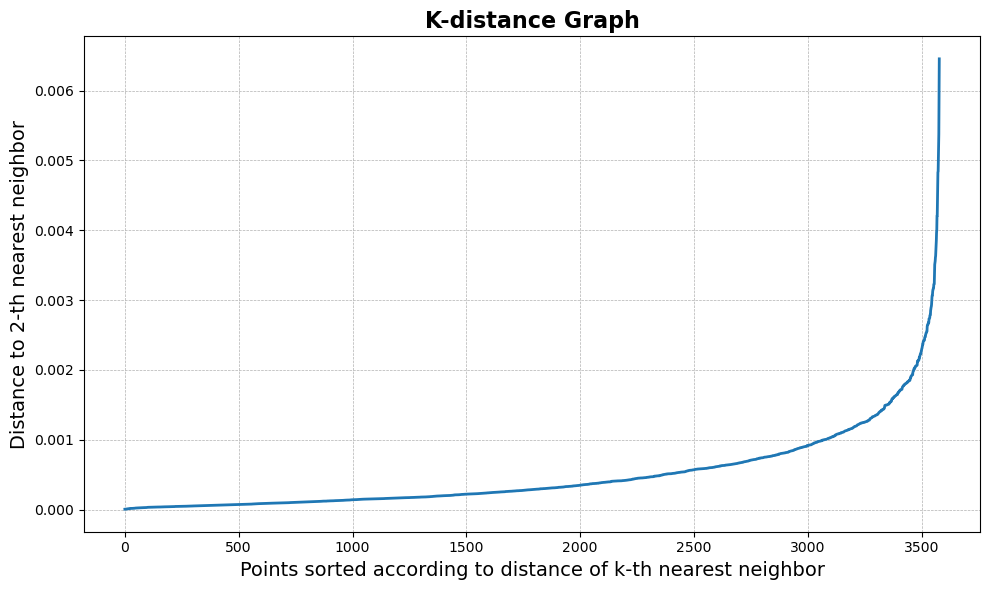

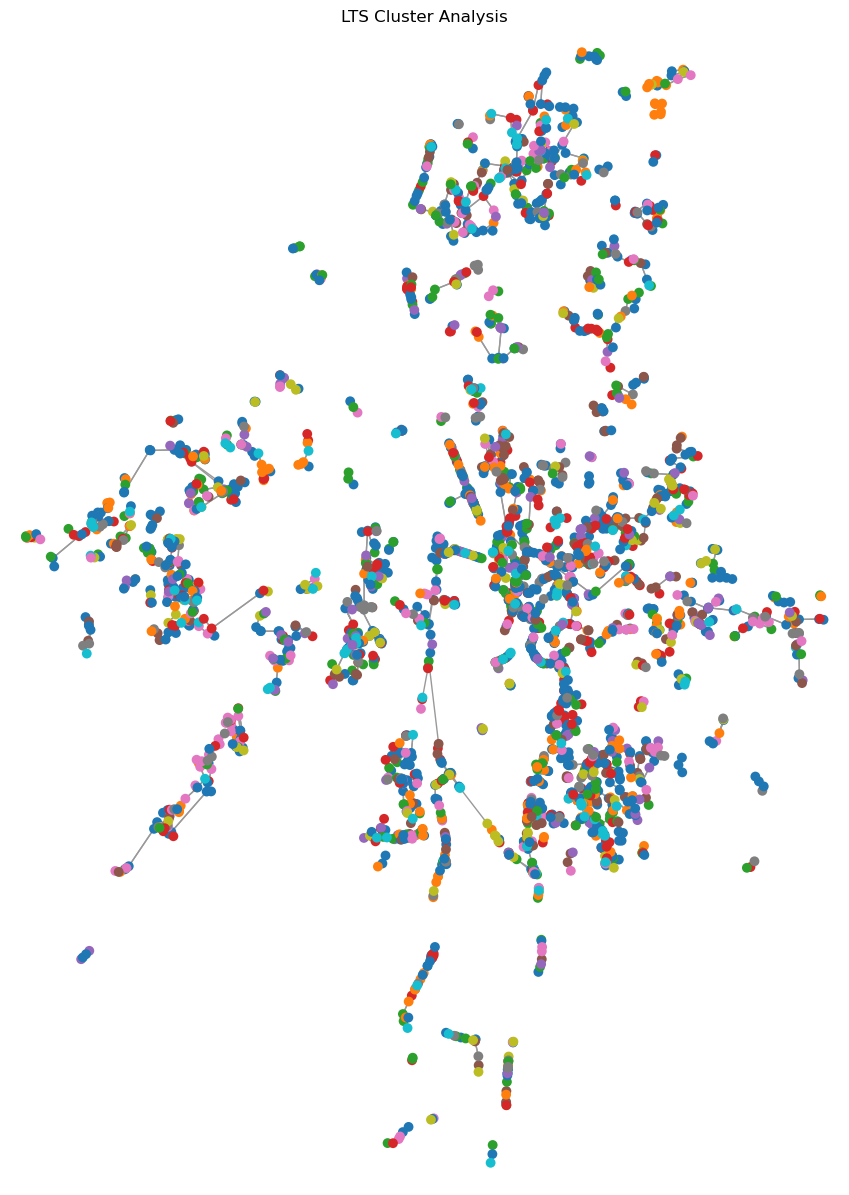

0.1534376746785914
Silhouette Score - DBSCAN: 0.26295199866721386
Davies-Bouldin Index - DBSCAN: 0.5557432401951655
Calinski-Harabasz Score - DBSCAN: 879.553434952548


In [7]:
## LTS Cluster Analysis:
## Use clustering algorithms to identify clusters of high-stress in the network.
## The clusters represent areas where there's a high level of traffic stress. 
# If you see many clusters close to each other or a large cluster, it indicates that particular region experiences high stress.
import osmnx as ox
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN,OPTICS
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.cm as cm

base_path = "/Users/leonardo/Desktop/Tesi/LTSBikePlan/images"
city_name = "Trento"

# Create the path for the new folder
city_folder_path = os.path.join(base_path, city_name)

# Create the folder if it doesn't exist
if not os.path.exists(city_folder_path):
    os.makedirs(city_folder_path)

# Load data
filepath = "/Users/leonardo/Desktop/Tesi/LTSBikePlan/data/Trento_lts.graphml"
G_lts = ox.load_graphml(filepath)
G_lts = ox.project_graph(G_lts, to_crs='EPSG:4326')
crs = G_lts.graph['crs']

def plot_k_distance_graph(features, k=2):
    """Plot the k-distance graph."""
    # Fit the Nearest Neighbors model
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(features)
    distances, _ = nbrs.kneighbors(features)
    
    # Sort the distances
    sorted_distances = np.sort(distances, axis=0)[:, 1]
    
    # Setup the plot aesthetics
    # sns.set_style('darkgrid')
    plt.figure(figsize=(10, 6))
    
    # Plot the k-distance graph
    plt.plot(sorted_distances, lw=2)
    plt.title('K-distance Graph', fontsize=16, fontweight='bold')
    plt.xlabel('Points sorted according to distance of k-th nearest neighbor', fontsize=14)
    plt.ylabel(f'Distance to {k}-th nearest neighbor', fontsize=14)
    plt.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

def cluster_nodes_by_stress(G):
    """Cluster nodes based on stress."""
    # Extract data
    node_data = [
        {'id': node, 'y': float(data['y']), 'x': float(data['x']), 'lts': int(data['lts'])} 
        for node, data in G.nodes(data=True) if 'lts' in data and int(data['lts']) == 4
    ]
    features = np.array([(data['y'], data['x']) for data in node_data])
    
    # Determine eps using k-distance graph
    plot_k_distance_graph(features)
    
    eps = float(input("Based on the elbow in the plot, enter the value for eps: "))
    
    # Setting min_samples
    D = features.shape[1]  # number of features, or dimensions
    min_samples = D + 1
    #density_factor = 2  # this can be adjusted based on the desired density
    #min_samples = base_min_samples * density_factor
    #min_samples = 3

    # DBSCAN Clustering
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(features)
    labels = db.labels_
    
    # Add cluster labels back to nodes
    for idx, data in enumerate(node_data):
        node = data['id']
        G.nodes[node]['cluster'] = labels[idx]
    
    return G, labels, features


def plot_clusters(G, save_path=None):

    fig, ax = plt.subplots(figsize=(15,15))

    # Set the background color of the figure and axis
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
        
    # Filter out nodes that don't have the 'cluster' attribute or are labeled as outliers (-1)
    filtered_nodes = [node for node in G.nodes() if 'cluster' in G.nodes[node] and G.nodes[node]['cluster'] != -1]
    
    # Get the 'cluster' attribute value for these nodes
    clusters = [G.nodes[node]['cluster'] for node in filtered_nodes]
    
    # Create a custom color map using a list of colors
    custom_cmap = plt.cm.get_cmap('tab10', len(np.unique(clusters)))

    # Map the cluster labels to the colors
    node_colors = [custom_cmap(cluster) for cluster in clusters]
    
    # Plot the subgraph of nodes with the 'cluster' attribute and aren't outliers
    graph = G.subgraph(filtered_nodes)
    ox.plot_graph(graph, node_color=node_colors, edge_linewidth=1.0, node_size=50, show=False, ax=ax)

    plt.title('LTS Cluster Analysis')
    if save_path:
        plt.savefig(os.path.join(save_path, "lts_cluster.png"))
    plt.show()


# Use:
cluster_nodes, labels, features = cluster_nodes_by_stress(G_lts)
plot_clusters(cluster_nodes, save_path=city_folder_path)

# Check noise labels exclusion:
noise_proportion = (labels == -1).sum() / len(labels)
print(noise_proportion)

# Exclude noise labels before calculating silhouette score
non_noise_indices = labels != -1

# Compute silhouette score excluding noise points
sil_score = silhouette_score(features[non_noise_indices], labels[non_noise_indices])
db_score = davies_bouldin_score(features[non_noise_indices], labels[non_noise_indices])
ch_score = calinski_harabasz_score(features[non_noise_indices], labels[non_noise_indices])
print(f"Silhouette Score - DBSCAN: {sil_score}")
print(f'Davies-Bouldin Index - DBSCAN: {db_score}')
print(f'Calinski-Harabasz Score - DBSCAN: {ch_score}')

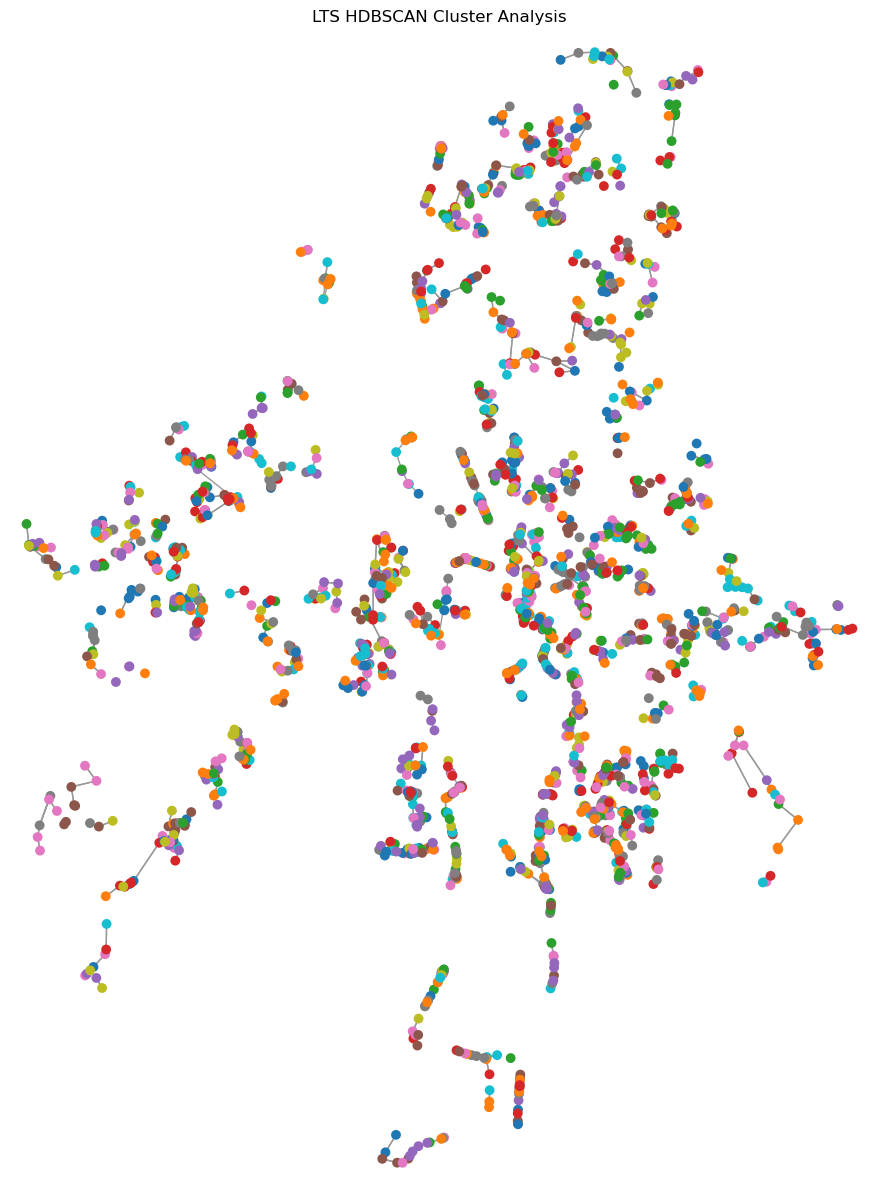

0.28870877585243154
Silhouette Score - HDBSCAN: 0.5891644311970766
Davies-Bouldin Index - HDBSCAN: 0.4870378646275686
Calinski-Harabasz Score - HDBSCAN: 7566.32035403482


In [8]:
#HDBSCAN cluster algorithm 

import hdbscan

def cluster_nodes_by_stress_hdbscan(G):
    # Extract data
    node_data = [
        {'id': node, 'y': float(data['y']), 'x': float(data['x']), 'lts': int(data['lts'])} 
        for node, data in G.nodes(data=True) if 'lts' in data and int(data['lts']) == 4
    ]
    features = np.array([(data['y'], data['x']) for data in node_data])

    # Setting min_cluster_size for HDBSCAN
    min_cluster_size = 4

    # HDBSCAN Clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    labels = clusterer.fit_predict(features)

    # Add cluster labels back to nodes
    for idx, data in enumerate(node_data):
        node = data['id']
        G.nodes[node]['cluster'] = labels[idx]
    
    return G, labels, features

def plot_clusters(G, save_path=None):
    fig, ax = plt.subplots(figsize=(15,15))

    # Set the background color of the figure and axis
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
        
    # Filter out nodes that don't have the 'cluster' attribute or are labeled as outliers (-1)
    filtered_nodes = [node for node in G.nodes() if 'cluster' in G.nodes[node] and G.nodes[node]['cluster'] != -1]
    
    # Get the 'cluster' attribute value for these nodes
    clusters = [G.nodes[node]['cluster'] for node in filtered_nodes]
    
    # Create a custom color map using a list of colors
    custom_cmap = plt.cm.get_cmap('tab10', len(np.unique(clusters)))

    # Map the cluster labels to the colors
    node_colors = [custom_cmap(cluster) for cluster in clusters]
    
    # Plot the subgraph of nodes with the 'cluster' attribute and aren't outliers
    graph = G.subgraph(filtered_nodes)
    ox.plot_graph(graph, node_color=node_colors, edge_linewidth=1.0, node_size=50, show=False, ax=ax)
    plt.title('LTS HDBSCAN Cluster Analysis')
    if save_path:
        plt.savefig(os.path.join(save_path, "lts_hdbscan_cluster.png"))
    plt.show()

# Use:
cluster_nodes, labels, features = cluster_nodes_by_stress_hdbscan(G_lts)
plot_clusters(cluster_nodes, city_folder_path)

# Check noise labels exclusion:
noise_proportion = (labels == -1).sum() / len(labels)
print(noise_proportion)

# Exclude noise labels before calculating silhouette score
non_noise_indices = labels != -1

# Compute silhouette score excluding noise points
sil_score = silhouette_score(features[non_noise_indices], labels[non_noise_indices])
db_score = davies_bouldin_score(features[non_noise_indices], labels[non_noise_indices])
ch_score = calinski_harabasz_score(features[non_noise_indices], labels[non_noise_indices])
print(f"Silhouette Score - HDBSCAN: {sil_score}")
print(f'Davies-Bouldin Index - HDBSCAN: {db_score}')
print(f'Calinski-Harabasz Score - HDBSCAN: {ch_score}')

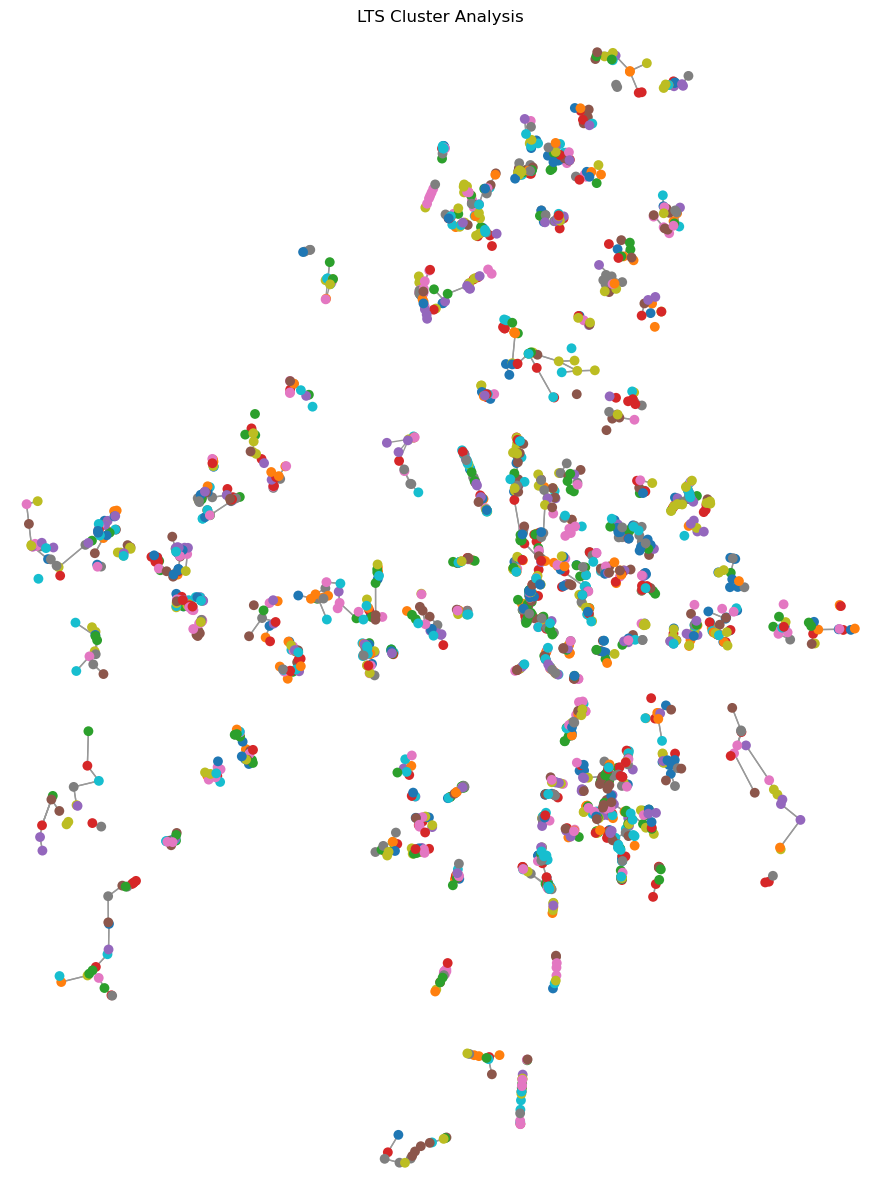

0.4178311906092789
Silhouette Score: 0.6387637022243012
Davies-Bouldin Index: 0.46639221236602807
Calinski-Harabasz Score: 9067.265750631546


In [9]:
def cluster_nodes_by_stress_optics(G):
    # Extract data
    node_data = [
        {'id': node, 'y': float(data['y']), 'x': float(data['x']), 'lts': int(data['lts'])} 
        for node, data in G.nodes(data=True) if 'lts' in data and int(data['lts']) == 4
    ]
    features = np.array([(data['y'], data['x']) for data in node_data])

    # OPTICS Clustering
    clusterer = OPTICS(min_samples=7) 
    labels = clusterer.fit_predict(features)

    # Add cluster labels back to nodes
    for idx, data in enumerate(node_data):
        node = data['id']
        G.nodes[node]['cluster'] = labels[idx]
    
    return G, labels, features

def plot_clusters(G,save_path=None):
    fig, ax = plt.subplots(figsize=(15,15))

    # Set the background color of the figure and axis
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
        
    # Filter out nodes that don't have the 'cluster' attribute or are labeled as outliers (-1)
    filtered_nodes = [node for node in G.nodes() if 'cluster' in G.nodes[node] and G.nodes[node]['cluster'] != -1]
    
    # Get the 'cluster' attribute value for these nodes
    clusters = [G.nodes[node]['cluster'] for node in filtered_nodes]
    
    # Create a custom color map using a list of colors
    custom_cmap = plt.cm.get_cmap('tab10', len(np.unique(clusters)))

    # Map the cluster labels to the colors
    node_colors = [custom_cmap(cluster) for cluster in clusters]
    
    # Plot the subgraph of nodes with the 'cluster' attribute and aren't outliers
    graph = G.subgraph(filtered_nodes)
    ox.plot_graph(graph, node_color=node_colors, edge_linewidth=1.0, node_size=50, show=False, ax=ax)

    plt.title('LTS Cluster Analysis')
    if save_path:
        plt.savefig(os.path.join(save_path, "lts_cluster_analysis_result.png"))
    plt.show()

# Use:
cluster_nodes, labels, features = cluster_nodes_by_stress_optics(G_lts)
plot_clusters(cluster_nodes, city_folder_path)

# Check noise labels exclusion:
noise_proportion = (labels == -1).sum() / len(labels)
print(noise_proportion)

# Exclude noise labels before calculating silhouette score
non_noise_indices = labels != -1

# Compute silhouette score excluding noise points
sil_score = silhouette_score(features[non_noise_indices], labels[non_noise_indices])
db_score = davies_bouldin_score(features[non_noise_indices], labels[non_noise_indices])
ch_score = calinski_harabasz_score(features[non_noise_indices], labels[non_noise_indices])
print(f"Silhouette Score: {sil_score}")
print(f'Davies-Bouldin Index: {db_score}')
print(f'Calinski-Harabasz Score: {ch_score}')